In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate
import math
from scipy.stats import f_oneway

# Import your Experiment class and related entities
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

In [2]:
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30

Loading + grouping

In [3]:
def load_experiments(data_folder):
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            file_path = os.path.join(data_folder, file)
            with open(file_path, "rb") as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

def get_sapap_genotype(genotype_string):
    """
    Robust-ish genotype parsing.
    Returns: "WT", "KO", or None
    """
    if genotype_string is None:
        return None

    g = str(genotype_string).upper()

    # Common lab variants
    if "KO" in g or "-/-" in g:
        return "KO"
    if "WT" in g or "+/+" in g:
        return "WT"
    # Keep your original pattern as a fallback: Sapap(WT) / Sapap(KO)
    if "SAPAP(" in g:
        start_index = g.find("SAPAP(") + len("SAPAP(")
        end_index = g.find(")", start_index)
        val = g[start_index:end_index].strip()
        if val in ("WT", "KO"):
            return val

    return None

def group_experiments_by_genotype(experiments):
    group_WT, group_KO, unknown = [], [], []

    for exp in experiments:
        genotype = get_sapap_genotype(getattr(exp, "Genotype", None))
        if genotype == "WT":
            group_WT.append(exp)
        elif genotype == "KO":
            group_KO.append(exp)
        else:
            unknown.append(exp)
            print(f"Warning: Unknown/missing genotype for Mouse {getattr(exp,'Mouse_id','?')} | Genotype={repr(getattr(exp,'Genotype',None))}")

    print(f"Number of WT mice: {len(group_WT)}")
    print(f"Number of KO mice: {len(group_KO)}")
    if len(unknown) > 0:
        print(f"Number of unknown genotype mice: {len(unknown)}")
    return group_WT, group_KO

Core extraction / averaging


In [4]:
def extract_zscore_and_time(experiments_group):
    """
    For a group of experiments, extract each experiment's z-score and time vectors.
    Experiments might have different lengths; we use the overlapping time range and
    interpolate onto a common time vector.

    Returns:
        avg_zscore, std_zscore, sem_zscore, common_time
    If group is empty -> returns (None, None, None, None)
    """
    if experiments_group is None or len(experiments_group) == 0:
        return None, None, None, None

    zscore_list = []
    time_list = []

    for exp in experiments_group:
        if not hasattr(exp, "GCaMP_data") or exp.GCaMP_data is None:
            continue
        if not hasattr(exp.GCaMP_data, "z_score") or not hasattr(exp.GCaMP_data, "time"):
            continue

        z = np.asarray(exp.GCaMP_data.z_score, dtype=float)
        t = np.asarray(exp.GCaMP_data.time, dtype=float)

        if z.size < 2 or t.size < 2:
            continue
        if z.size != t.size:
            # If mismatched, skip to avoid subtle bugs
            print(f"Warning: size mismatch for Mouse {getattr(exp,'Mouse_id','?')} (time={t.size}, z={z.size}). Skipping.")
            continue

        zscore_list.append(z)
        time_list.append(t)

    if len(time_list) == 0:
        return None, None, None, None

    # overlapping time window
    start_time = max(t[0] for t in time_list)
    end_time = min(t[-1] for t in time_list)

    if end_time <= start_time:
        print("Warning: No overlapping time window across experiments in this group.")
        return None, None, None, None

    # estimate dt from first experiment
    dt = float(np.mean(np.diff(time_list[0])))
    if not np.isfinite(dt) or dt <= 0:
        print("Warning: Invalid dt computed. Aborting group averaging.")
        return None, None, None, None

    common_time = np.arange(start_time, end_time, dt)

    if common_time.size < 2:
        print("Warning: Common time vector too short.")
        return None, None, None, None

    # interpolate each trace to common time
    interp_zscores = []
    for t, z in zip(time_list, zscore_list):
        interp_z = np.interp(common_time, t, z)
        interp_zscores.append(interp_z)

    zscore_array = np.vstack(interp_zscores)  # shape: (n_mice, n_timepoints)

    avg_zscore = np.mean(zscore_array, axis=0)
    std_zscore = np.std(zscore_array, axis=0)
    sem_zscore = std_zscore / np.sqrt(zscore_array.shape[0])

    return avg_zscore, std_zscore, sem_zscore, common_time


def compute_dynamic_y_limits(*traces, padding=0.2, tick_step=0.5):
    """
    Compute y-limits from any number of traces (ignoring None).
    Returns (ymin, ymax) rounded to nearest tick_step.
    """
    valid = [tr for tr in traces if tr is not None]
    if len(valid) == 0:
        return None

    ymin = min(np.min(tr) for tr in valid) - padding
    ymax = max(np.max(tr) for tr in valid) + padding

    # round to tick_step
    inv = 1.0 / tick_step
    new_ymin = math.floor(ymin * inv) / inv
    new_ymax = math.ceil(ymax * inv) / inv
    return (new_ymin, new_ymax)


Plotting

In [5]:
def plot_average_trace(time, avg_trace, group_label, color, sem=None,
                       y_limits=None, y_tick_interval=None,
                       x_limits=None, x_tick_interval=None):
    """
    Plots the average GCaMP z-score trace (and SEM if provided).
    If time/avg_trace is None -> silently skip.
    """
    if time is None or avg_trace is None:
        print(f"Skipping plot for {group_label}: no data.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(time, avg_trace, color=color, linewidth=1, label=f"{group_label} Average")
    if sem is not None:
        plt.fill_between(time, avg_trace - sem, avg_trace + sem, color=color, alpha=0.3, label=f"{group_label} SEM")

    plt.xlabel("Time (s)", fontsize=16)
    plt.ylabel("GCaMP Z Score", fontsize=16)
    plt.title(f"Average GCaMP Z Score Trace - {group_label} Group", fontsize=18)

    if y_limits is not None:
        plt.ylim(y_limits)
        if y_tick_interval is not None:
            yticks = np.arange(y_limits[0], y_limits[1] + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)

    if x_limits is not None:
        plt.xlim(x_limits)
        if x_tick_interval is not None:
            xticks = np.arange(x_limits[0], x_limits[1] + x_tick_interval, x_tick_interval)
            plt.xticks(xticks)
    else:
        xticks = np.arange(time[0], time[-1] + 600, 600)
        plt.xticks(xticks)

    plt.legend(fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


def plot_combined_average_traces(time_wt, avg_wt, sem_wt,
                                 time_ko, avg_ko, sem_ko,
                                 y_limits=None, y_tick_interval=None,
                                 x_limits=None, x_tick_interval=None):
    """
    Plots WT and KO average traces on same axes.
    If one group missing -> plots only the available group(s).
    """
    if (time_wt is None or avg_wt is None) and (time_ko is None or avg_ko is None):
        print("Skipping combined plot: no data in either group.")
        return

    plt.figure(figsize=(12, 6))

    plotted_any = False

    if time_wt is not None and avg_wt is not None:
        plt.plot(time_wt, avg_wt, color="#2400f5", linewidth=2, label="WT Average + SEM")
        if sem_wt is not None:
            plt.fill_between(time_wt, avg_wt - sem_wt, avg_wt + sem_wt, color="#2400f5", alpha=0.3)
        plotted_any = True

    if time_ko is not None and avg_ko is not None:
        plt.plot(time_ko, avg_ko, color="#ce2900", linewidth=2, label="KO Average + SEM")
        if sem_ko is not None:
            plt.fill_between(time_ko, avg_ko - sem_ko, avg_ko + sem_ko, color="#ce2900", alpha=0.3)
        plotted_any = True

    if not plotted_any:
        print("Skipping combined plot: nothing to plot.")
        return

    plt.xlabel("Time (s)", fontsize=16)
    plt.ylabel("GCaMP Z-Score", fontsize=16)
    plt.title("Group Averaged GCaMP Trace (Z-Score)", fontsize=18)

    if y_limits is not None:
        plt.ylim(y_limits)
        if y_tick_interval is not None:
            yticks = np.arange(y_limits[0], y_limits[1] + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)
    else:
        ax = plt.gca()
        plt.draw()
        auto_ylim = ax.get_ylim()
        new_ymin = math.floor(auto_ylim[0] * 2) / 2
        new_ymax = math.ceil(auto_ylim[1] * 2) / 2
        plt.ylim(new_ymin, new_ymax)
        if y_tick_interval is not None:
            yticks = np.arange(new_ymin, new_ymax + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)

    # x-axis ticks: prefer WT, else KO
    ref_time = time_wt if (time_wt is not None and avg_wt is not None) else time_ko

    if x_limits is not None:
        plt.xlim(x_limits)
        if x_tick_interval is not None:
            xticks = np.arange(x_limits[0], x_limits[1] + x_tick_interval, x_tick_interval)
            plt.xticks(xticks)
    else:
        xticks = np.arange(ref_time[0], ref_time[-1] + 600, 600)
        plt.xticks(xticks)

    plt.legend(fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


Binning

In [6]:
def bin_average_trace(time, avg_trace, bin_size=10):
    """
    Compute mean z-score in bins of bin_size seconds (anchored at 0).
    Returns (bin_centers, binned_avg).
    If missing inputs -> returns (None, None)
    """
    if time is None or avg_trace is None:
        return None, None

    bins = np.arange(0, time[-1] + bin_size, bin_size)
    bin_centers = []
    binned_avg = []

    for i in range(len(bins) - 1):
        mask = (time >= bins[i]) & (time < bins[i + 1])
        if np.any(mask):
            binned_avg.append(np.mean(avg_trace[mask]))
            bin_centers.append((bins[i] + bins[i + 1]) / 2)

    if len(bin_centers) == 0:
        return None, None

    return np.asarray(bin_centers), np.asarray(binned_avg)


def plot_binned_averages(bins_wt, binned_avg_wt, bins_ko, binned_avg_ko,
                         x_limits=None, x_tick_interval=None,
                         y_limits=None, y_tick_interval=None,
                         title="Binned Averages"):
    """
    Plot binned averages; plots only available groups.
    """
    if (bins_wt is None or binned_avg_wt is None) and (bins_ko is None or binned_avg_ko is None):
        print("Skipping binned plot: no data in either group.")
        return

    plt.figure(figsize=(10, 6))

    if bins_wt is not None and binned_avg_wt is not None:
        plt.plot(bins_wt, binned_avg_wt, marker="o", markersize=4, color="blue", label="WT Binned Average")

    if bins_ko is not None and binned_avg_ko is not None:
        plt.plot(bins_ko, binned_avg_ko, marker="o", markersize=4, color="red", label="KO Binned Average")

    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Binned Avg GCaMP Z Score", fontsize=14)
    plt.title(title, fontsize=16)

    if y_limits is not None:
        plt.ylim(y_limits)
        if y_tick_interval is not None:
            yticks = np.arange(y_limits[0], y_limits[1] + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)

    if x_limits is not None:
        plt.xlim(x_limits)
        if x_tick_interval is not None:
            xticks = np.arange(x_limits[0], x_limits[1] + x_tick_interval, x_tick_interval)
            plt.xticks(xticks)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()



ANOVA

In [7]:
def _window_means_for_group(experiments_group, t_start, t_end):
    """
    For each experiment, compute mean z-score in [t_start, t_end).
    Returns list of per-mouse means.
    """
    values = []
    if experiments_group is None:
        return values

    for exp in experiments_group:
        if not hasattr(exp, "GCaMP_data") or exp.GCaMP_data is None:
            continue
        time_vec = np.asarray(exp.GCaMP_data.time, dtype=float)
        zscore = np.asarray(exp.GCaMP_data.z_score, dtype=float)
        if time_vec.size == 0 or zscore.size == 0:
            continue

        mask = (time_vec >= t_start) & (time_vec < t_end)
        if np.any(mask):
            values.append(float(np.mean(zscore[mask])))

    return values


def run_anova_for_time_window(group_WT, group_KO, t_start, t_end):
    """
    Runs one-way ANOVA comparing WT vs KO for window [t_start, t_end).
    If one group missing or too few samples -> skip gracefully.
    """
    wt_values = _window_means_for_group(group_WT, t_start, t_end)
    ko_values = _window_means_for_group(group_KO, t_start, t_end)

    # Need at least 2 groups with >=2 samples each for a reasonable ANOVA
    if len(wt_values) < 2 or len(ko_values) < 2:
        print(f"ANOVA skipped (Time {t_start}-{t_end}s): insufficient data "
              f"(WT n={len(wt_values)}, KO n={len(ko_values)}).")
        return None, None

    F_statistic, p_value = f_oneway(wt_values, ko_values)

    if p_value < 0.05:
        sig = "Significant!"
    elif 0.05 <= p_value < 0.1:
        sig = "Almost sig (p = 0.05 - 0.1)"
    else:
        sig = "No significant difference"

    print(f"ANOVA (Time {t_start} to {t_end} s): F={F_statistic:.4f}, p={p_value:.4f} -> {sig}")
    return float(F_statistic), float(p_value)


def run_anova_for_multiple_time_windows(group_WT, group_KO, overall_start, overall_end, bin_size=10):
    """
    Runs ANOVA for sequential bins. Skips bins that don’t have enough data.
    Returns list of (t_start, t_end, F, p) where F/p can be None.
    """
    results = []
    bins = np.arange(overall_start, overall_end, bin_size)

    for b in bins:
        t_start = float(b)
        t_end = float(b + bin_size)
        F_statistic, p_value = run_anova_for_time_window(group_WT, group_KO, t_start, t_end)
        results.append((t_start, t_end, F_statistic, p_value))

    return results

Main

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Loaded: M546_eEPA_R_adBNST.pkl
Loaded: M561_eEPA_R_adBNST.pkl
Total .pkl files loaded: 15
Number of WT mice: 7
Number of KO mice: 8


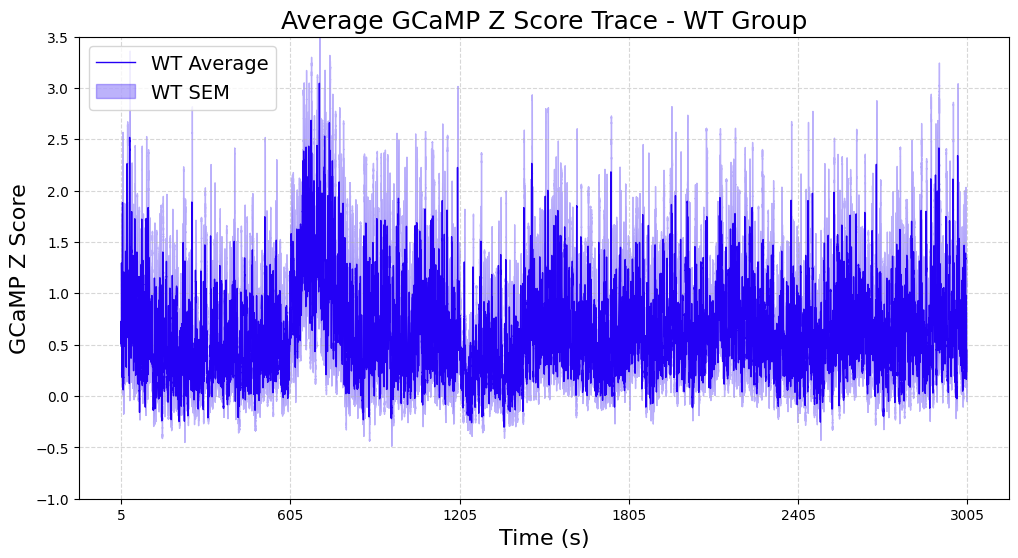

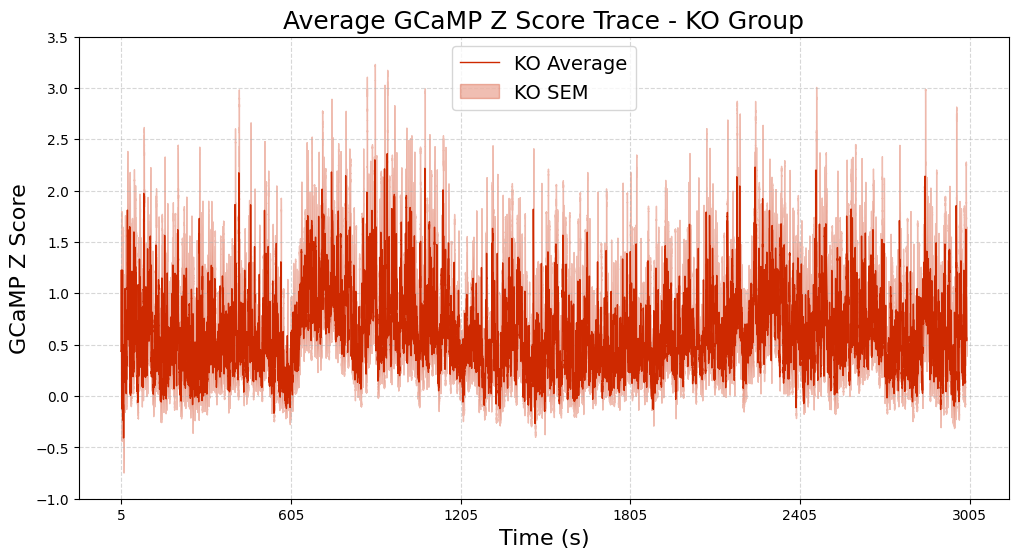

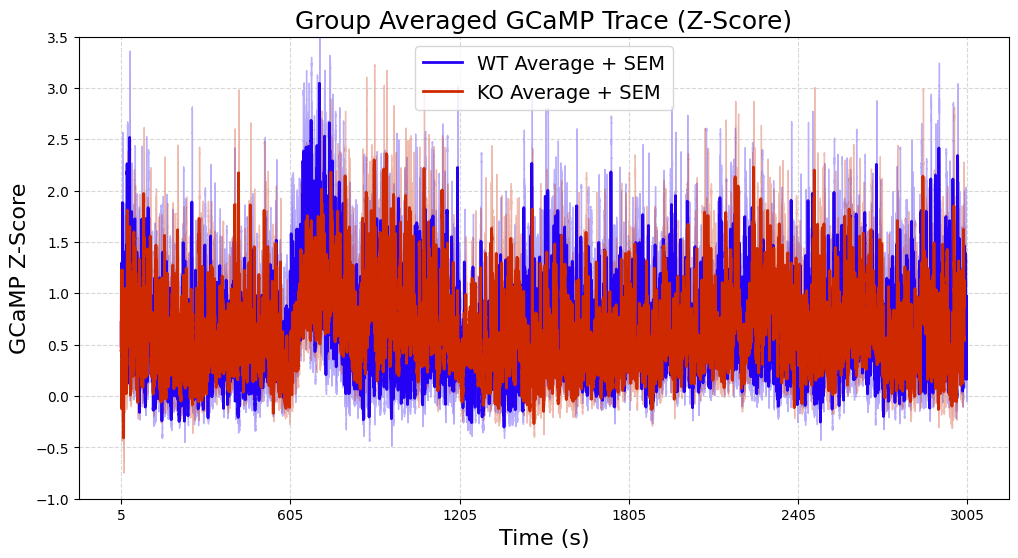

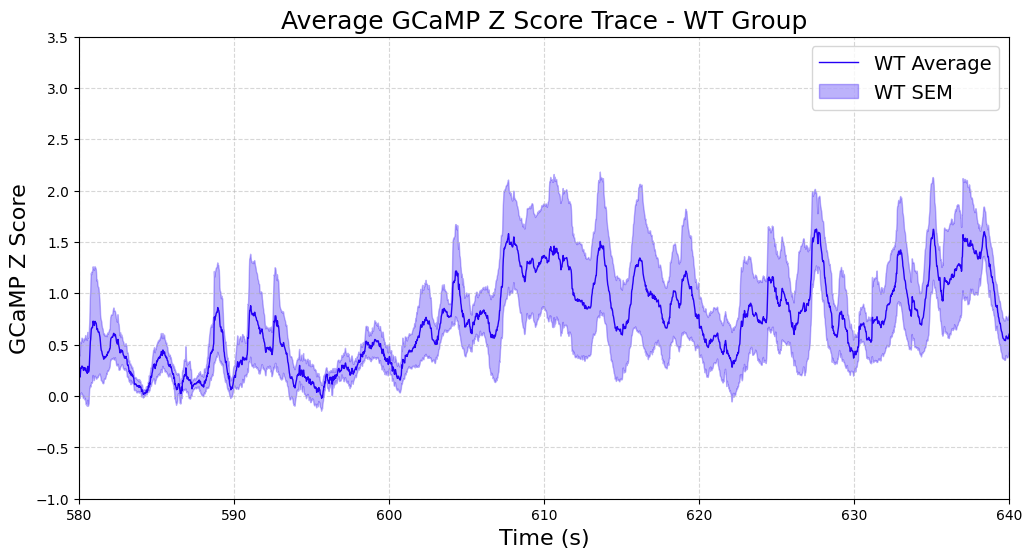

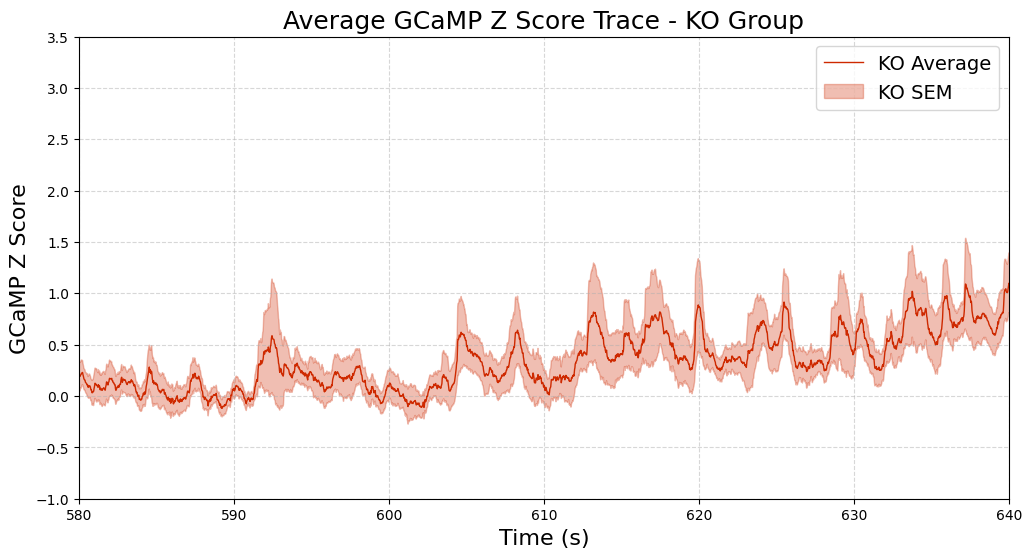

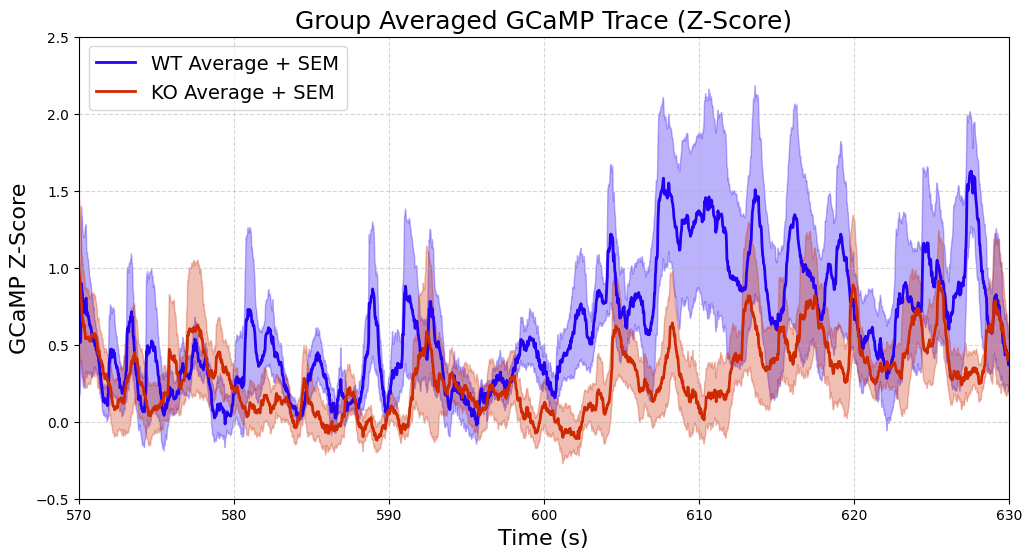

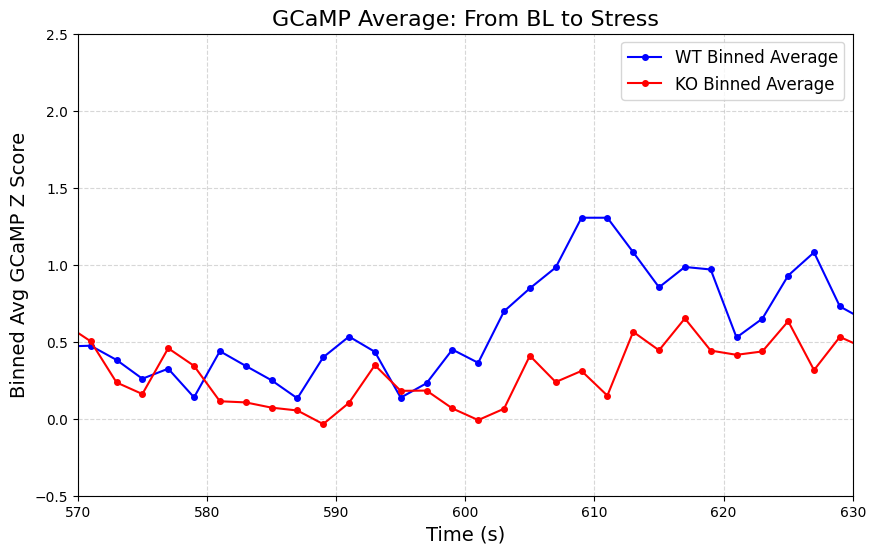

ANOVA (Time 570.0 to 575.0 s): F=0.1078, p=0.7478 -> No significant difference
ANOVA (Time 575.0 to 580.0 s): F=0.4148, p=0.5307 -> No significant difference
ANOVA (Time 580.0 to 585.0 s): F=1.4135, p=0.2557 -> No significant difference
ANOVA (Time 585.0 to 590.0 s): F=3.0598, p=0.1038 -> No significant difference
ANOVA (Time 590.0 to 595.0 s): F=0.5113, p=0.4872 -> No significant difference
ANOVA (Time 595.0 to 600.0 s): F=0.9798, p=0.3403 -> No significant difference
ANOVA (Time 600.0 to 605.0 s): F=4.2742, p=0.0592 -> Almost sig (p = 0.05 - 0.1)
ANOVA (Time 605.0 to 610.0 s): F=3.1835, p=0.0977 -> Almost sig (p = 0.05 - 0.1)
ANOVA (Time 610.0 to 615.0 s): F=1.5215, p=0.2392 -> No significant difference
ANOVA (Time 615.0 to 620.0 s): F=0.6348, p=0.4399 -> No significant difference
ANOVA (Time 620.0 to 625.0 s): F=0.2788, p=0.6064 -> No significant difference
ANOVA (Time 625.0 to 630.0 s): F=1.2607, p=0.2818 -> No significant difference


In [8]:
if __name__ == "__main__":
    # Load experiments
    experiments = load_experiments(DATA_FOLDER)

    # Group by genotype
    group_WT, group_KO = group_experiments_by_genotype(experiments)

    # Extract averages
    avg_wt, std_wt, sem_wt, time_wt = extract_zscore_and_time(group_WT)
    avg_ko, std_ko, sem_ko, time_ko = extract_zscore_and_time(group_KO)

    # Dynamic y limits computed from whatever exists
    y_tick_interval = 0.5
    dynamic_y_limits = compute_dynamic_y_limits(avg_wt, avg_ko, padding=0.1, tick_step=y_tick_interval)

    # Plot: individual group traces (only if present)
    plot_average_trace(time_wt, avg_wt, group_label="WT", color="#2400f5",
                       y_limits=dynamic_y_limits, y_tick_interval=y_tick_interval, sem=sem_wt)

    plot_average_trace(time_ko, avg_ko, group_label="KO", color="#ce2900",
                       y_limits=dynamic_y_limits, y_tick_interval=y_tick_interval, sem=sem_ko)

    # Combined plot (plots what exists)
    plot_combined_average_traces(time_wt, avg_wt, sem_wt,
                                 time_ko, avg_ko, sem_ko,
                                 y_limits=dynamic_y_limits, y_tick_interval=y_tick_interval)

    # Zoomed windows (only if that group exists)
    plot_average_trace(time_wt, avg_wt, group_label="WT", color="#2400f5",
                       y_limits=dynamic_y_limits, y_tick_interval=y_tick_interval,
                       x_limits=(580, 640), x_tick_interval=10, sem=sem_wt)

    plot_average_trace(time_ko, avg_ko, group_label="KO", color="#ce2900",
                       y_limits=dynamic_y_limits, y_tick_interval=y_tick_interval,
                       x_limits=(580, 640), x_tick_interval=10, sem=sem_ko)

    plot_combined_average_traces(time_wt, avg_wt, sem_wt,
                                 time_ko, avg_ko, sem_ko,
                                 y_limits=(-0.5, 2.5), y_tick_interval=y_tick_interval,
                                 x_limits=(570, 630), x_tick_interval=10)

    # Binned averages (works with missing groups)
    bins_wt, binned_avg_wt = bin_average_trace(time_wt, avg_wt, bin_size=2)
    bins_ko, binned_avg_ko = bin_average_trace(time_ko, avg_ko, bin_size=2)

    plot_binned_averages(bins_wt, binned_avg_wt, bins_ko, binned_avg_ko,
                         x_limits=(570, 630), x_tick_interval=10,
                         y_limits=(-0.5, 2.5), y_tick_interval=0.5,
                         title="GCaMP Average: From BL to Stress")

    # ANOVA (skips gracefully if missing / too few samples)
    results = run_anova_for_multiple_time_windows(group_WT, group_KO, 570, 630, bin_size=5)